# Exploratory Data Analysis
I first load the real estate data from Boston. I will focus on properties sold in the last three months. This EDA is to understand the data before I try to build features and model to predict the selling price.

First, let's look at missing values, outliers, basic trends and patterns which can be used to predict the selling price.

       ZIP OR POSTAL CODE         PRICE         BEDS        BATHS  \
count         7912.000000  7.912000e+03  7912.000000  7912.000000   
mean          2135.722573  8.453707e+05     2.273129     1.699096   
std             58.959919  8.436503e+05     1.055816     0.776875   
min            211.000000  1.080000e+05     0.000000     1.000000   
25%           2118.000000  4.690000e+05     2.000000     1.000000   
50%           2127.000000  6.181875e+05     2.000000     1.500000   
75%           2131.000000  8.720000e+05     3.000000     2.000000   
max           2472.000000  1.720000e+07    10.000000     9.000000   

        SQUARE FEET      LOT SIZE   YEAR BUILT  $/SQUARE FEET     HOA/MONTH  \
count   7912.000000  7.912000e+03  7881.000000    7912.000000  7.912000e+03   
mean    1307.247219  7.576832e+04  1938.678340     667.929221  1.364376e+04   
std     1327.218718  2.585519e+06    50.710792     349.028474  3.560023e+05   
min      238.000000  0.000000e+00  1668.000000       6.000000 

<IPython.core.display.Javascript object>


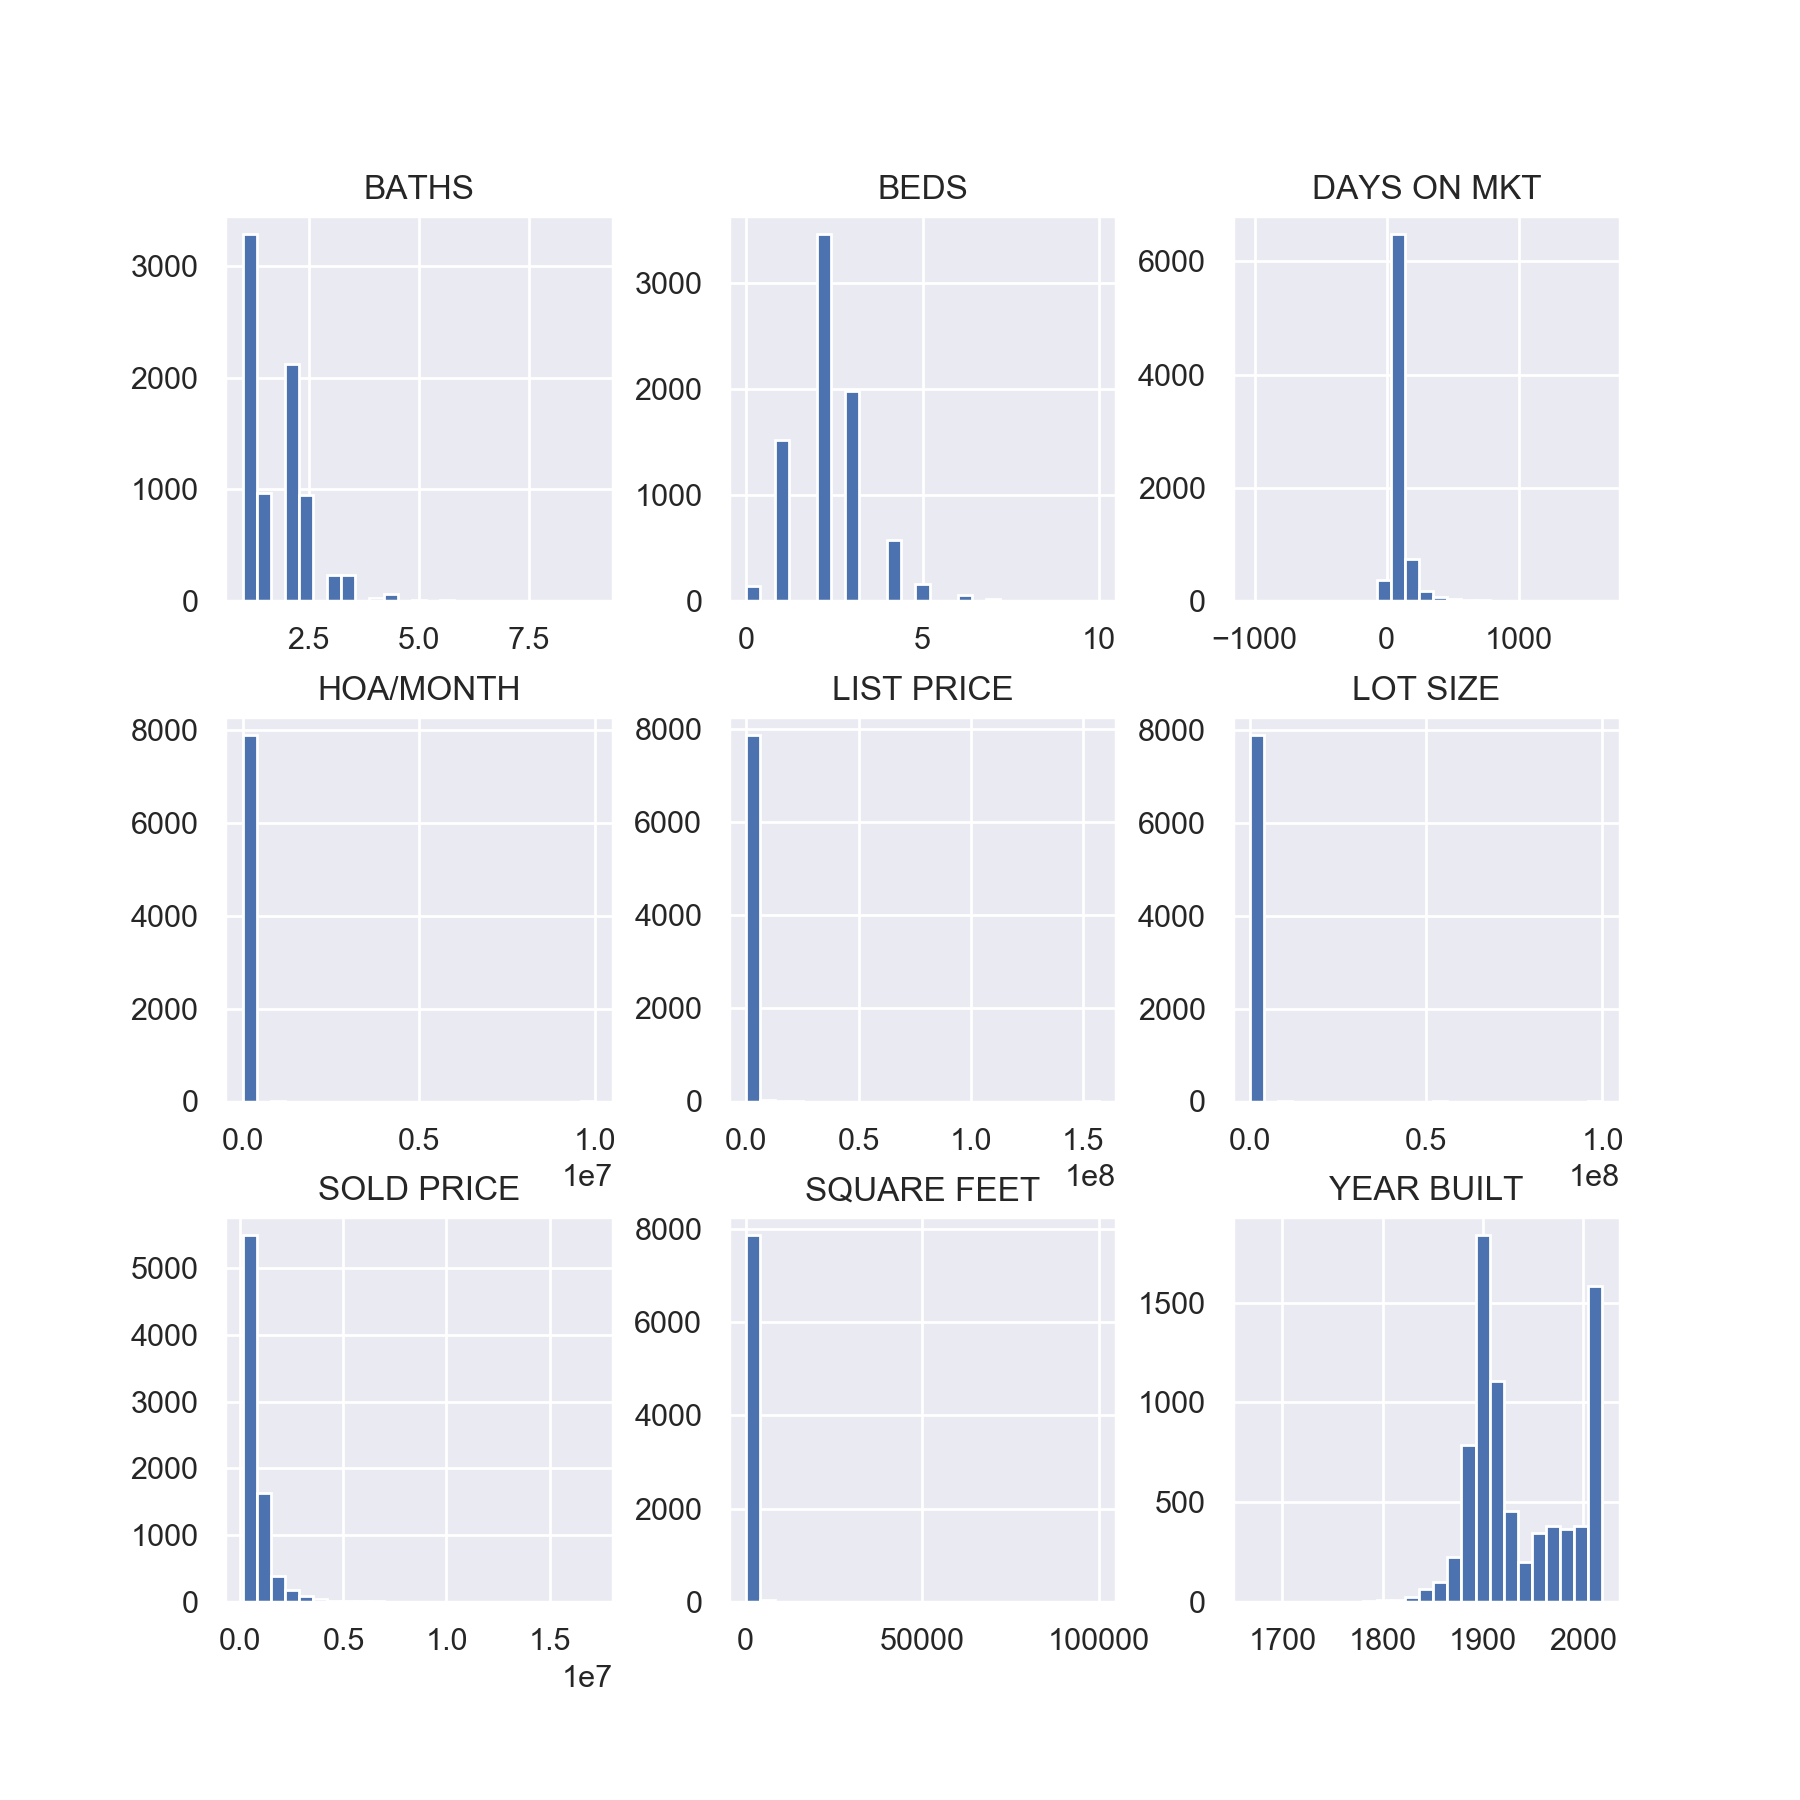

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a9f0126d8>,
      dtype=object)

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns

sns.set()

import sys

sys.path.append('~/PycharmProjects/Boston_housing/')

df_master = pd.read_csv('../data/raw/' + 'redfin_2020-01-19-08-17-26.csv')
df_master.pop('SOLD DATE')
df_master.pop('DAYS ON MARKET') # days on market on the original csv doesn't seem to be accurate 
                                # compared to the scraped price history.
df_condo = pd.read_csv('../data/processed/' + 'Boston_condo_transaction.csv',index_col=0)
df_sfr = pd.read_csv('../data/processed/' + 'Boston_single_family_residential_transaction.csv',index_col=0)
df_townhouse = pd.read_csv('../data/processed/' + 'Boston_townhouse_transaction.csv',index_col=0)

df_transaction = pd.concat([df_condo,df_sfr,df_townhouse])

df = df_master.join(df_transaction,how='inner')

df['SOLD DATE'] = pd.to_datetime(df['SOLD DATE'])
df['LIST DATE'] = pd.to_datetime(df['LIST DATE'])
df['DAYS ON MKT'] = (df['SOLD DATE'] - df['LIST DATE']).apply(lambda x: x.days)
df['HOA/MONTH'] = df['HOA/MONTH'].fillna(0)
df['LOT SIZE'] = df['LOT SIZE'].fillna(0) # if no parking lot, lot size = 0.
df['PREMIUM'] = (df['SOLD PRICE'] - df['LIST PRICE'])/df['LIST PRICE']

df.pop('NEXT OPEN HOUSE START TIME')
df.pop('NEXT OPEN HOUSE END TIME')
df.pop('MLS#')


print(df.describe())

df[['BEDS','BATHS','SQUARE FEET','LOT SIZE','YEAR BUILT',
    'HOA/MONTH','LIST PRICE','SOLD PRICE','DAYS ON MKT']].hist(
    bins=25, layout=(3,3), figsize=(9,9))

# Dealing with outliers

From the histograms, we see there are outliers that heavily skewed the list price, sold price, size and days on market distribution. Naturally, very large houses (e.g. mansions) are much more expansive than 90% of the houses.
Let's take a closer look at these four distributions.


<IPython.core.display.Javascript object>


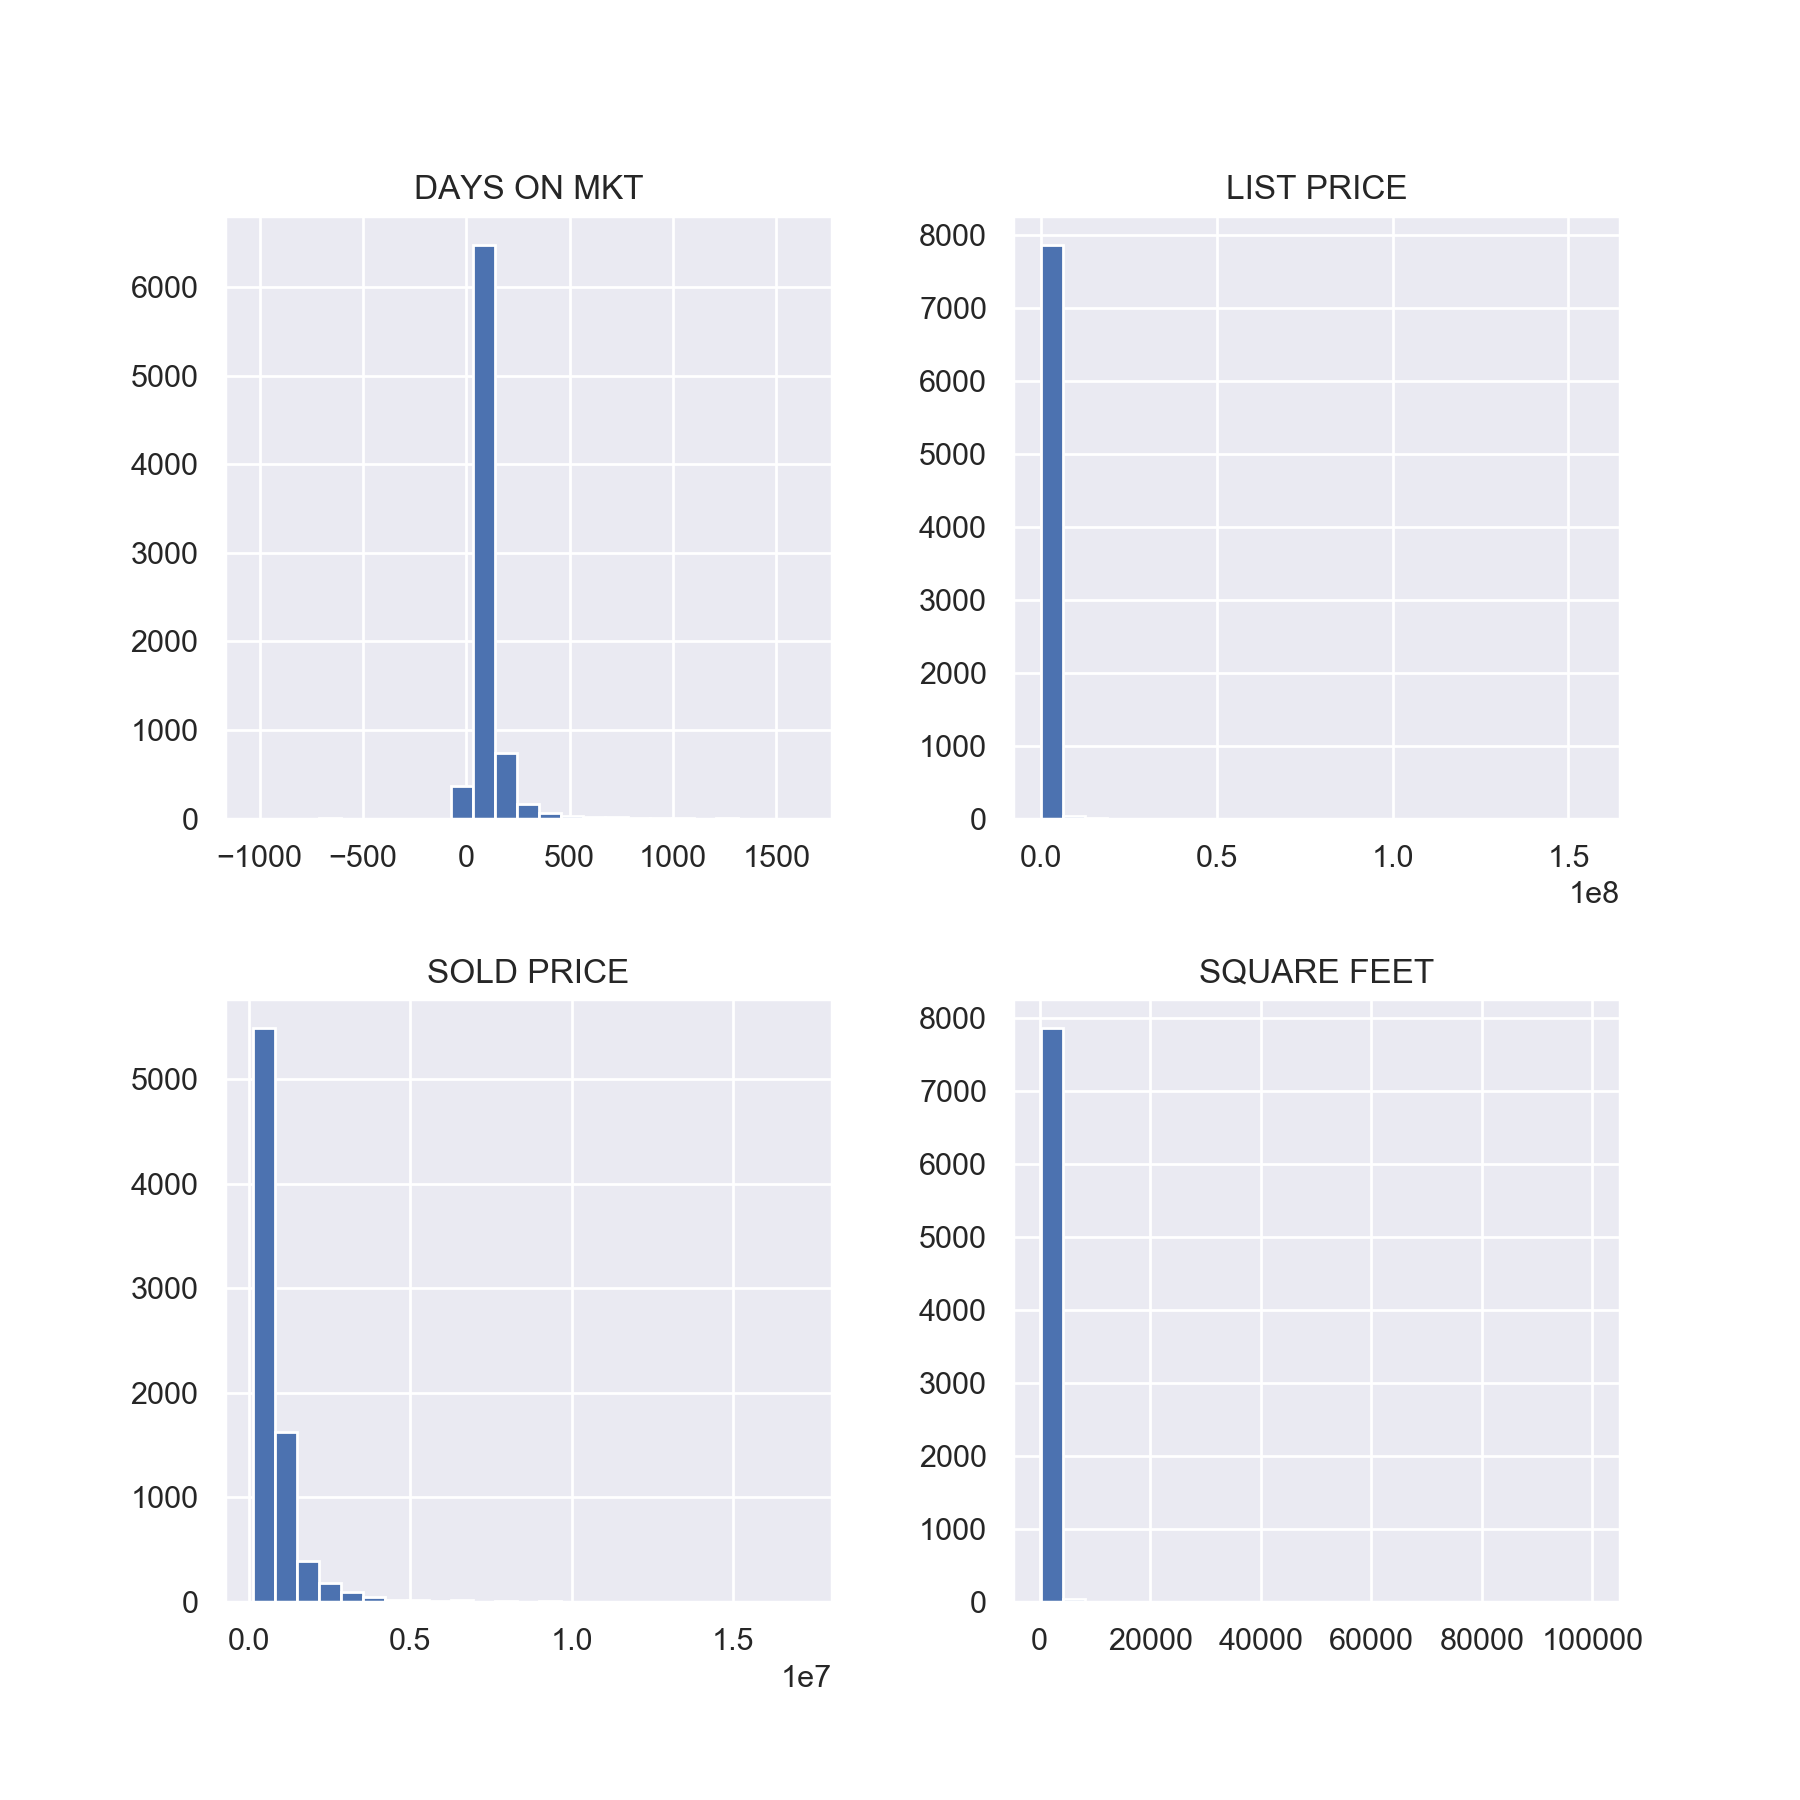

<IPython.core.display.Javascript object>


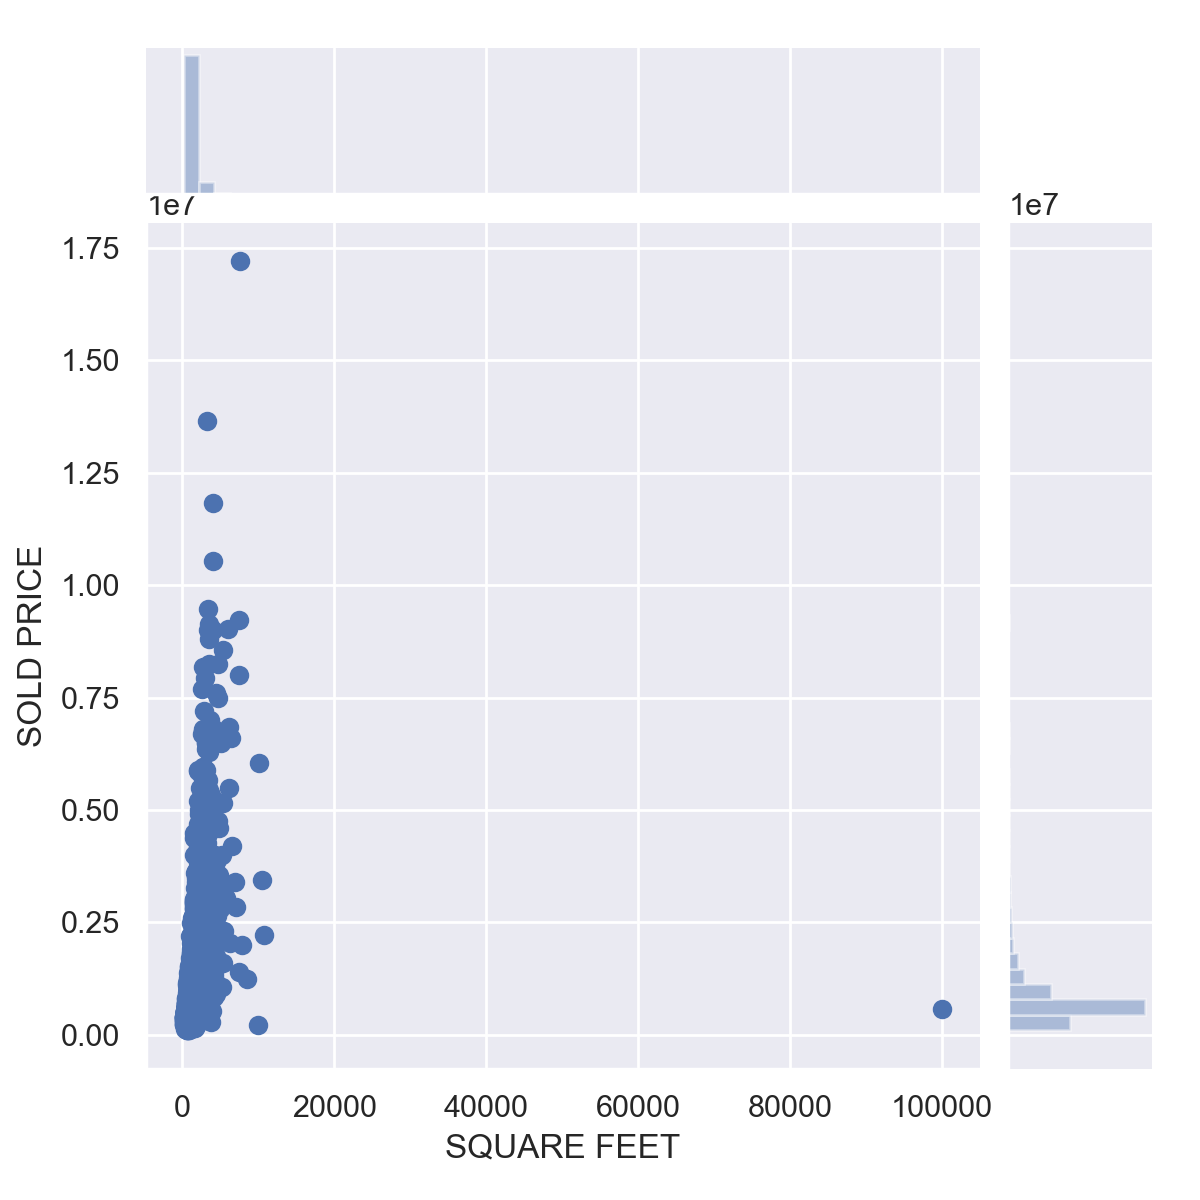

In [210]:

df[['SQUARE FEET',
    'LIST PRICE','SOLD PRICE','DAYS ON MKT']].hist(
    bins=25, layout=(2,2), figsize=(9,9))

sns.jointplot('SQUARE FEET', "SOLD PRICE", data=df)


In general, larger property are sold at a higher price, except for one point (property with 100,000 sqft but sold at around \$500,000). I decided to ignore these 'mega' houses by dropping houses that are beyond the (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR) range. Note that this will also potentiall remove houses that are not mega house. Therefore, in reality, it is a good practice to see whether we can determine if each house does or doesn't belong to an outlier.

number of data before outlier removal:  7912
number of data after outlier removal:  6048
number of data after removing new data:  6046


<IPython.core.display.Javascript object>


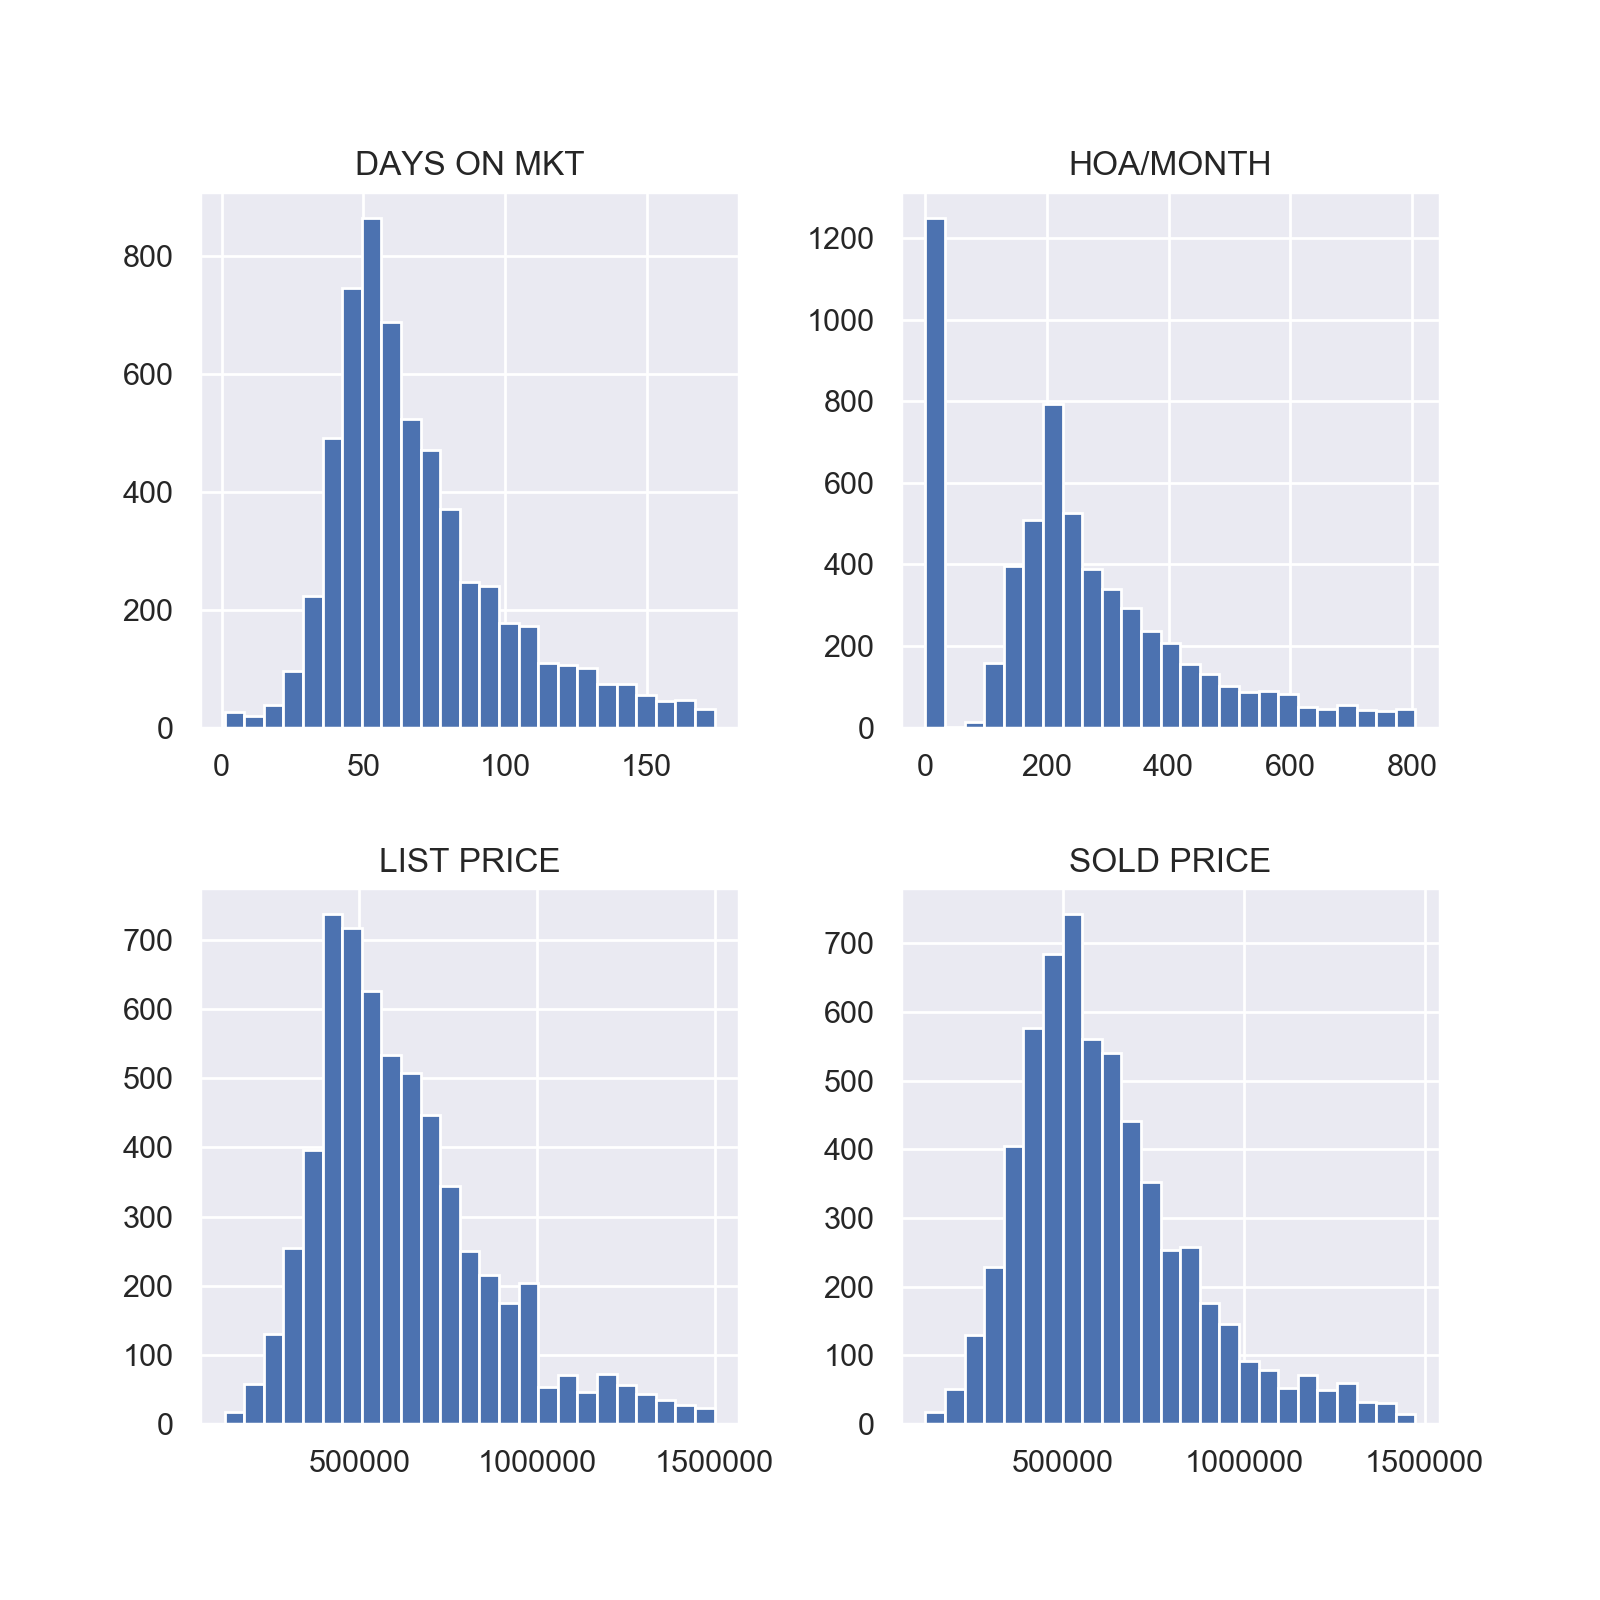

In [211]:
import numpy as np

def upper_outlier(x):
    return  np.quantile(x,0.75) + 1.5*(np.quantile(x,0.75)-np.quantile(x,0.25))

def lower_outlier(x):
    return  np.quantile(x,0.25) - 1.5*(np.quantile(x,0.75)-np.quantile(x,0.25))


df_upper_outlier = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH','PREMIUM']].apply(
    lambda x: upper_outlier(x),axis=0)
df_lower_outlier = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH','PREMIUM']].apply(
    lambda x: lower_outlier(x),axis=0)

print('number of data before outlier removal: ',len(df))

df = df[(df['DAYS ON MKT'] < df_upper_outlier['DAYS ON MKT'])&
        (df['SOLD PRICE'] < df_upper_outlier['SOLD PRICE']) &
        (df['LIST PRICE'] < df_upper_outlier['LIST PRICE']) &
        (df['HOA/MONTH'] < df_upper_outlier['HOA/MONTH']) &
        (df['PREMIUM'] < df_upper_outlier['PREMIUM']) &
        (df['DAYS ON MKT'] > df_lower_outlier['DAYS ON MKT']) &
        (df['SOLD PRICE'] > df_lower_outlier['SOLD PRICE']) & 
        (df['LIST PRICE'] > df_lower_outlier['LIST PRICE']) &
        (df['PREMIUM'] > df_lower_outlier['PREMIUM'])]


print('number of data after outlier removal: ',len(df))

df = df[df['DAYS ON MKT'] > 0] # price history scraped after the spreadsheet
df = df[np.abs((df['SOLD PRICE']-df['LIST PRICE'])/df['LIST PRICE']) < 1] # typo in listing/selling price

print('number of data after removing new data: ',len(df))


ax_list = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH']].hist(
    bins=25, layout=(2,2), figsize=(8,8))

# Correlations and trends
Let's take a look at correlations between different features. We will investigate the correlations by property type (condo, single family residential and townhouse).

<IPython.core.display.Javascript object>


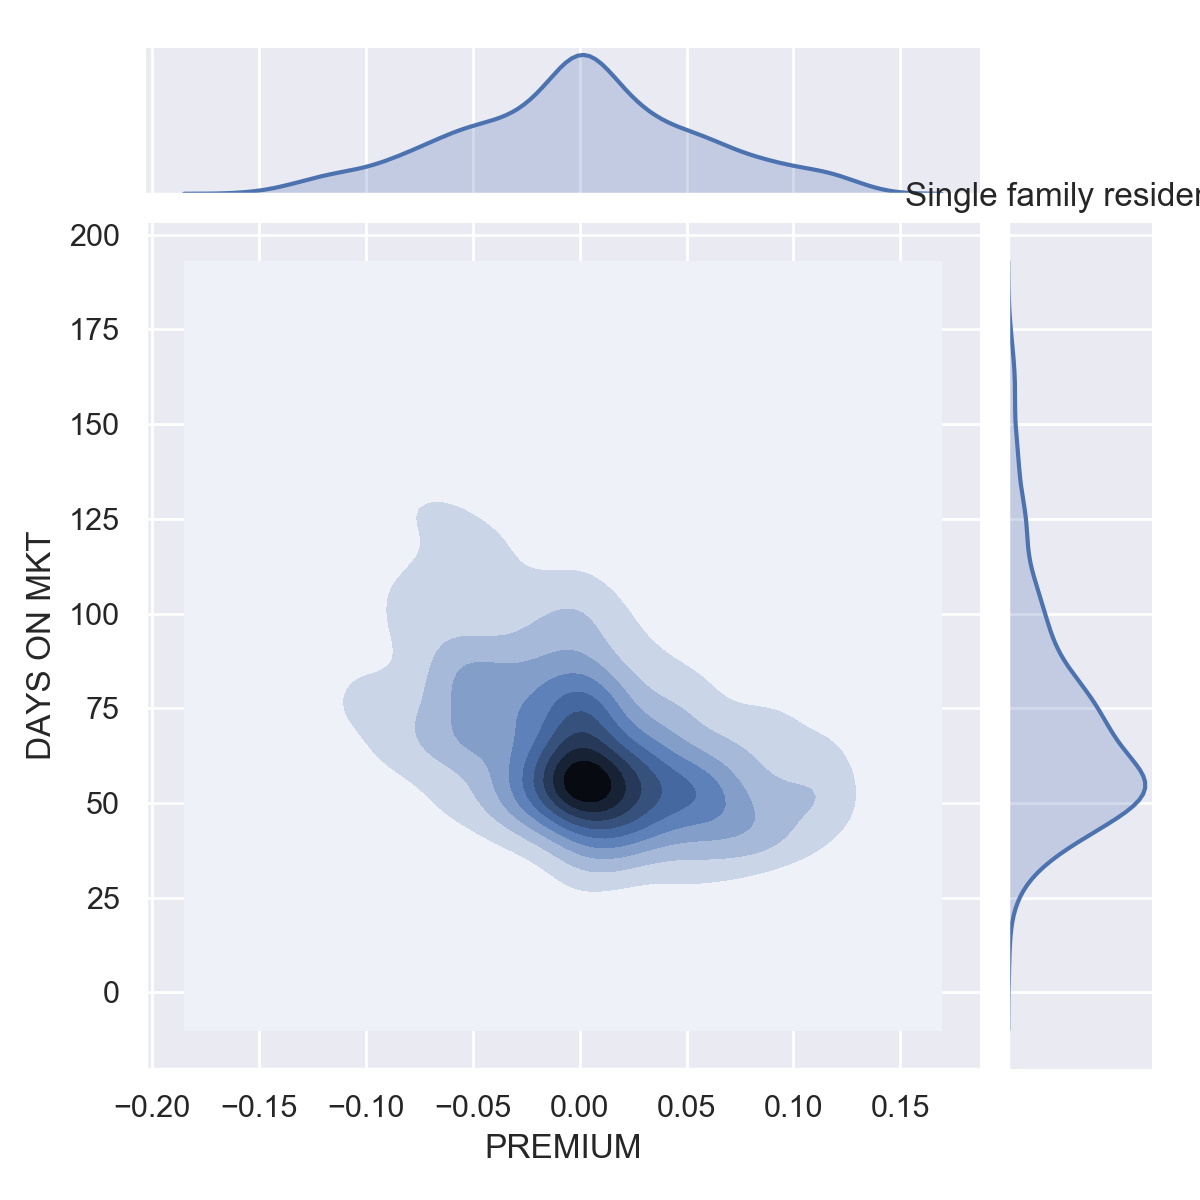

<IPython.core.display.Javascript object>


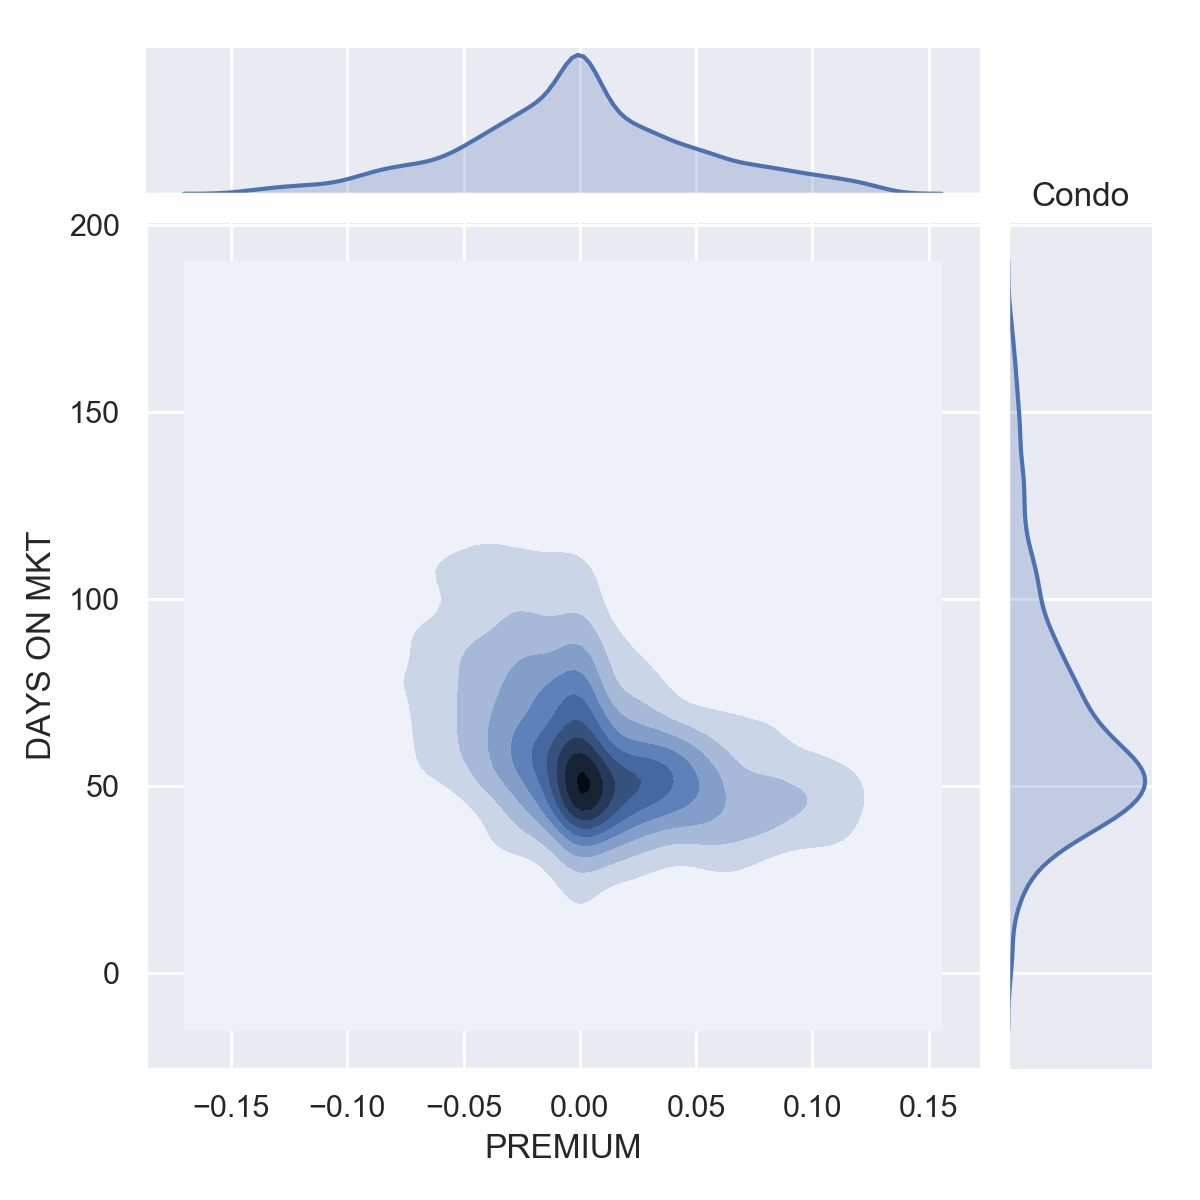

<IPython.core.display.Javascript object>


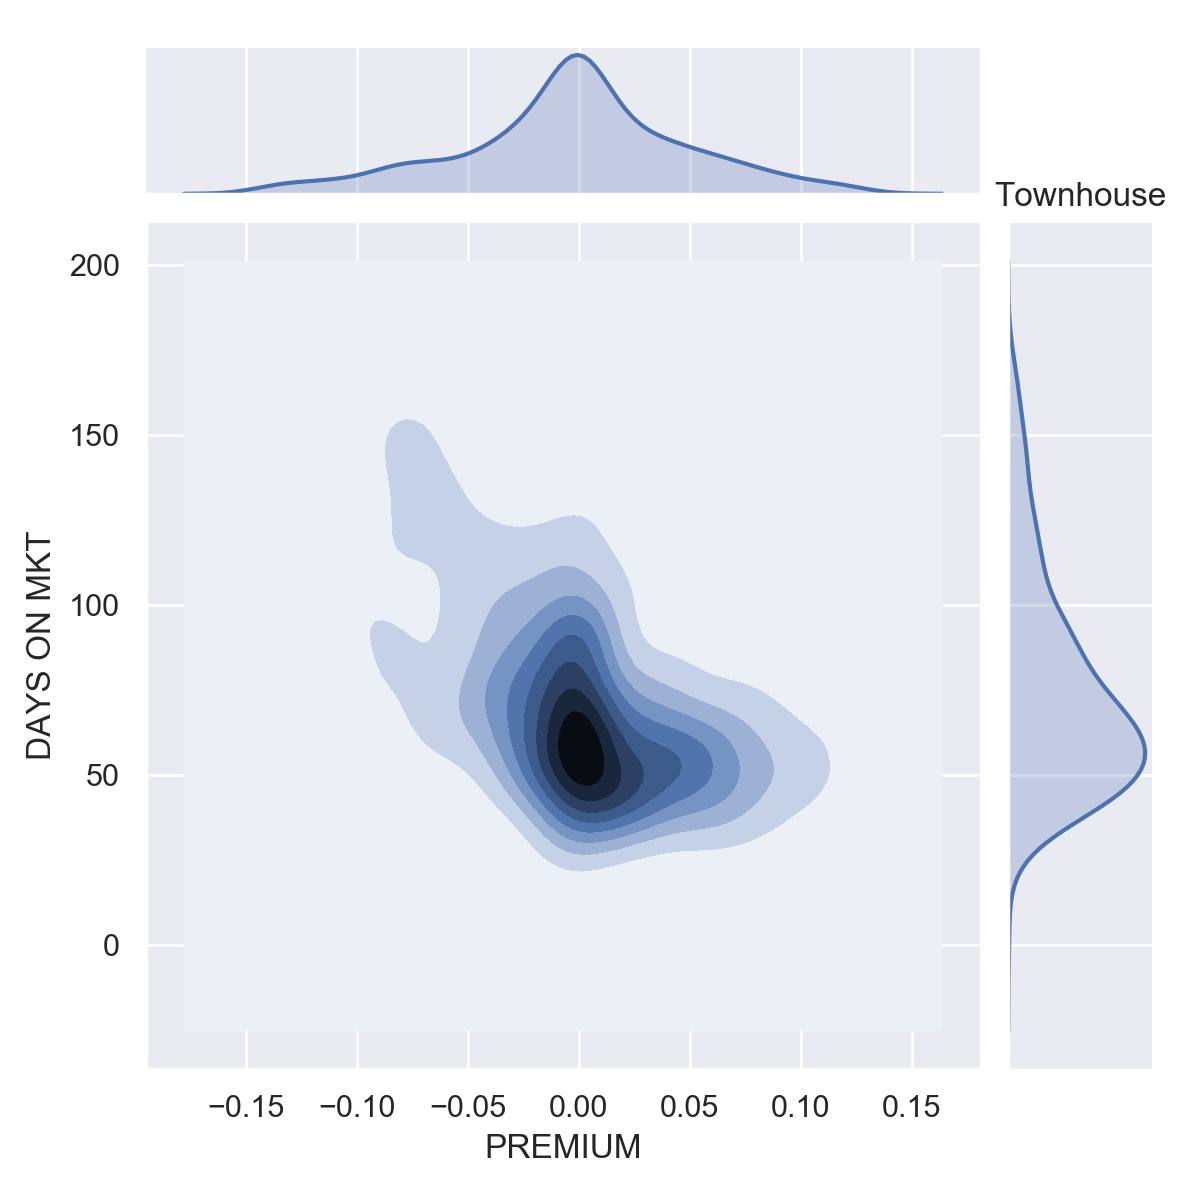

In [225]:
import matplotlib.pyplot as plt
%matplotlib notebook



#df_prop = df[df['PROPERTY TYPE']=='Single Family Residential']


sns.jointplot('PREMIUM', "DAYS ON MKT", data=df[df['PROPERTY TYPE']=='Single Family Residential'],
             kind='kde')
plt.title('Single family residential')


sns.jointplot('PREMIUM', "DAYS ON MKT", data=df[df['PROPERTY TYPE']=='Condo/Co-op'],
             kind='kde')
plt.title('Condo')


sns.jointplot('PREMIUM', "DAYS ON MKT", data=df[df['PROPERTY TYPE']=='Townhouse'],
             kind='kde')
plt.title('Townhouse')
plt.show()

The general trend, for all property types, is that houses sold belong the listing price usually take stay on the market longer.

# Selling staistics of houses in different zipcodes
How do the selling price in each neighborhood compare? The simpliest way to define neighborhood is by its zipcode. I do a boxplot of selling price in each zipcode and sort it by their medians from high to low.

<IPython.core.display.Javascript object>


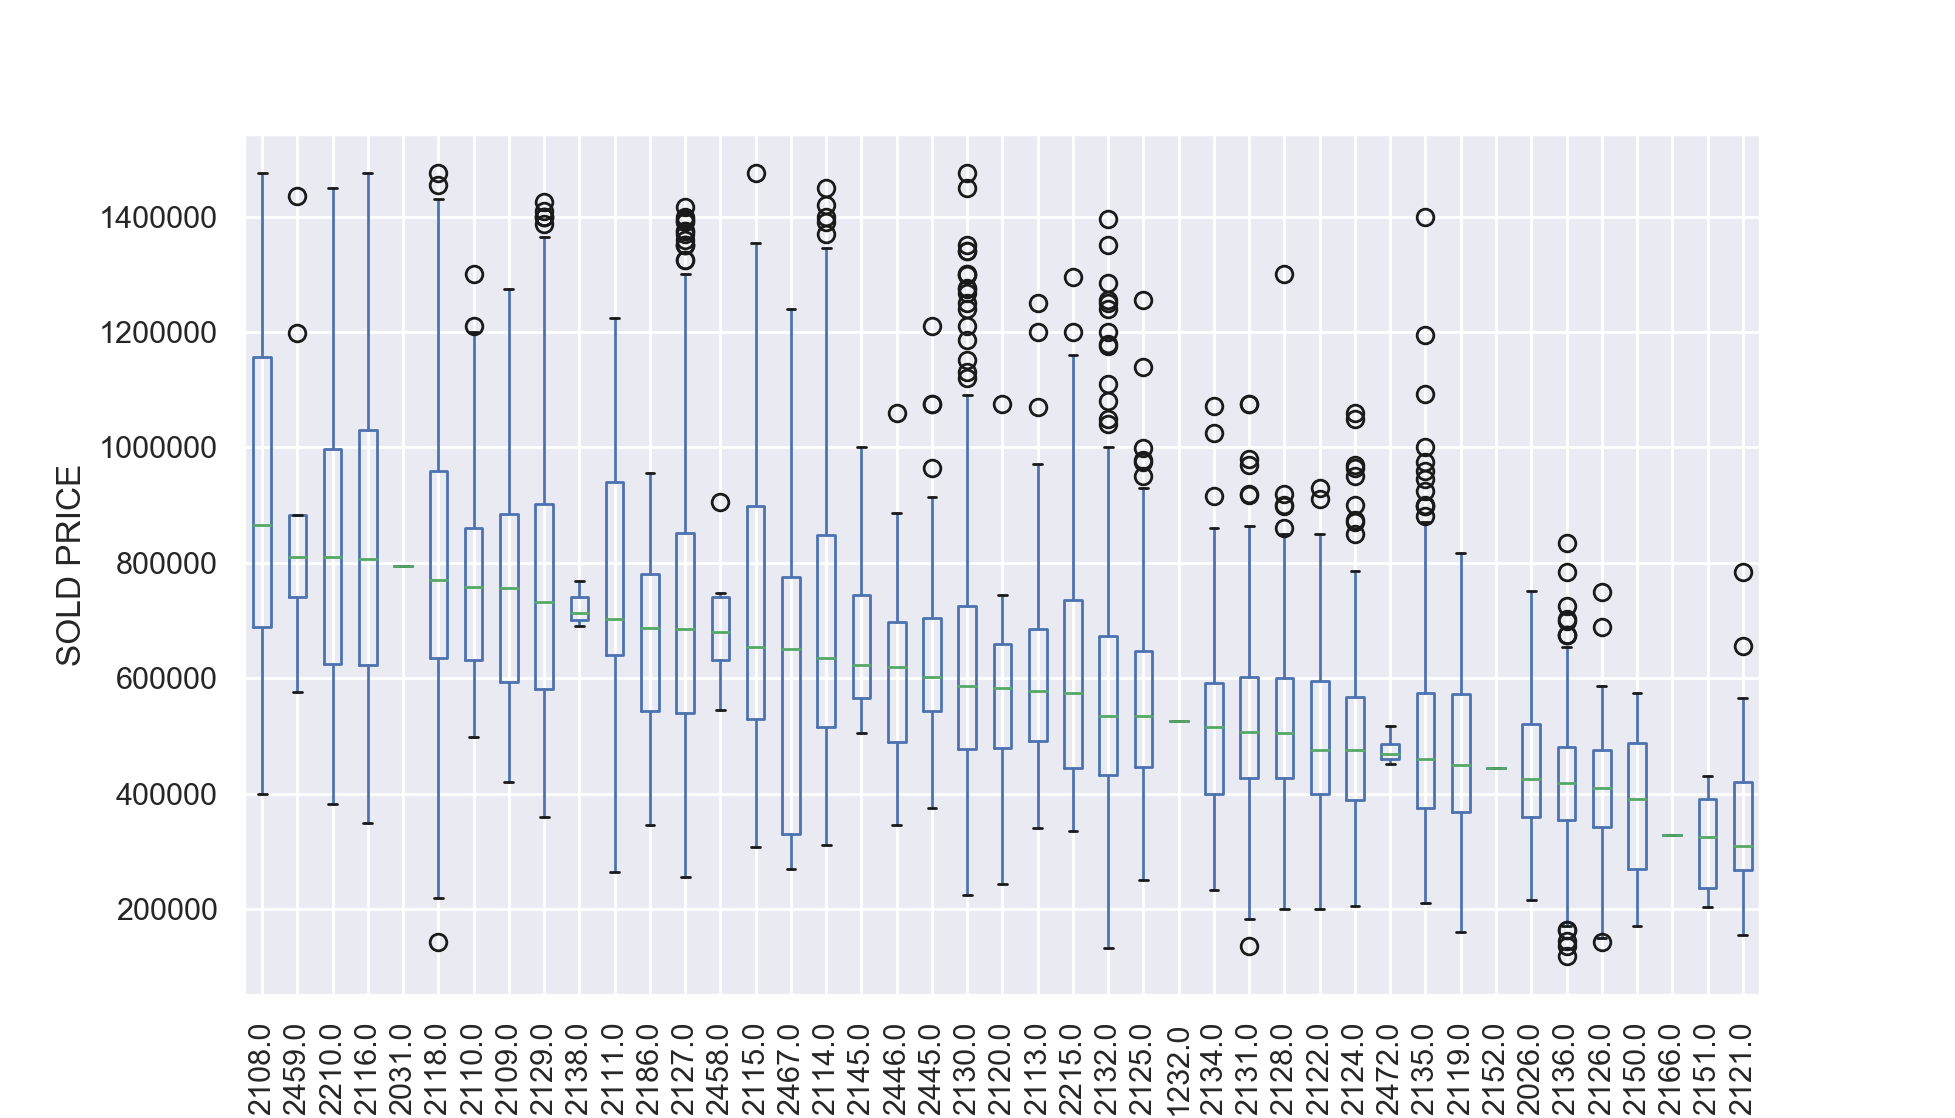

In [229]:
df_core = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH','ZIP OR POSTAL CODE']]

df_pivot = df_core.pivot(columns='ZIP OR POSTAL CODE',values='SOLD PRICE')

meds = df_pivot.median()
meds.sort_values(ascending=False, inplace=True)
df_pivot = df_pivot[meds.index]

fig = plt.figure()
df_pivot.boxplot(column=df_pivot.columns.tolist())
plt.xticks(rotation=90)
plt.ylabel('SOLD PRICE')
plt.show()



<IPython.core.display.Javascript object>


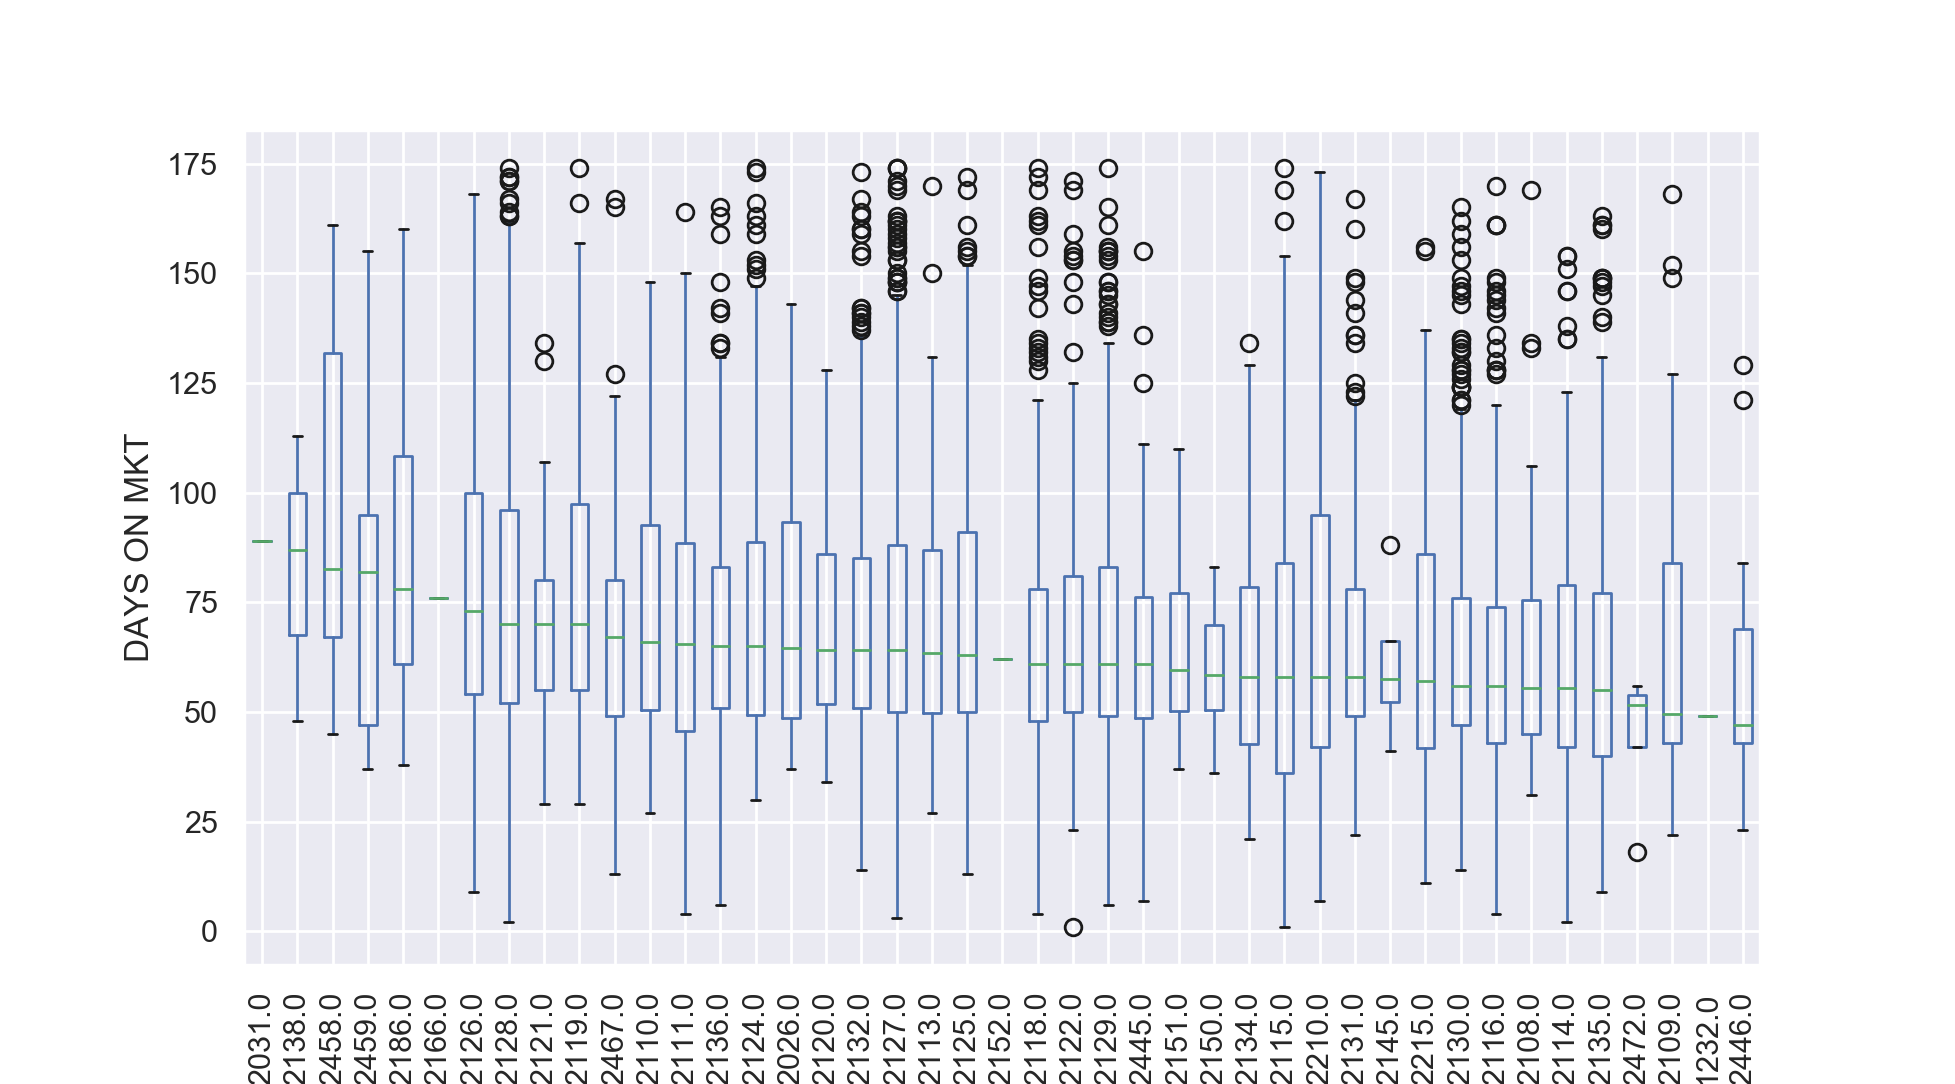

In [268]:
df_pivot = df_core.pivot(columns='ZIP OR POSTAL CODE',values='DAYS ON MKT')

meds = df_pivot.median()
meds.sort_values(ascending=False, inplace=True)
df_pivot = df_pivot[meds.index]

fig = plt.figure()
df_pivot.boxplot(column=df_pivot.columns.tolist())
plt.xticks(rotation=90)
plt.ylabel('DAYS ON MKT')
plt.show()

The difference between the median price of the most expensive neighborhood and the least expensive neighborhood is over \$500,000. And the difference between the days on market is over 40 days (5.7 weeks). However, it is a poor choice to use solely the neighborhood to predict the housing price and the days on market due to the huge variation within the neighborhood.

# Comparing selling statistics of different property types

<IPython.core.display.Javascript object>


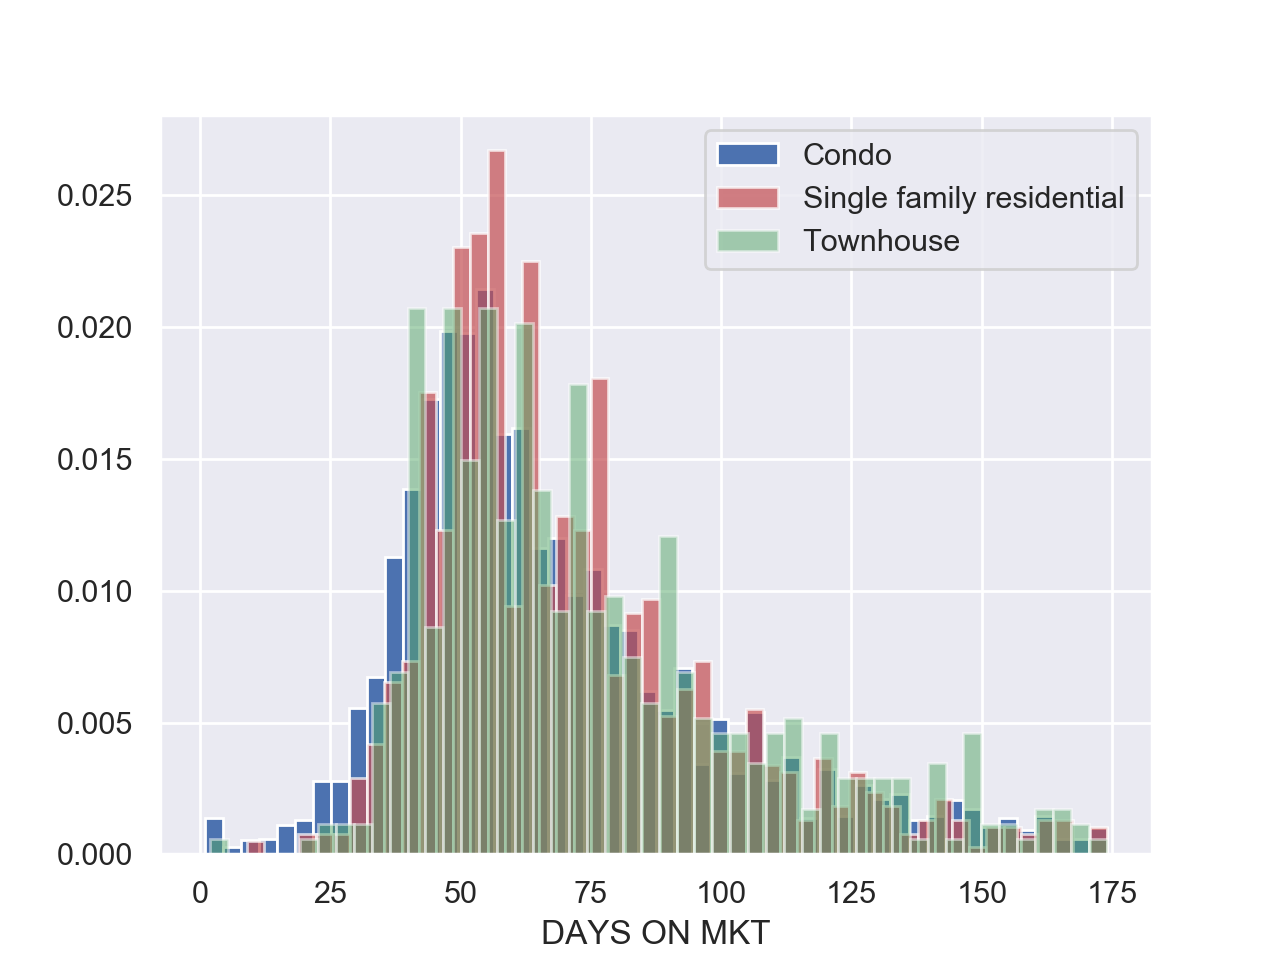

//anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<IPython.core.display.Javascript object>


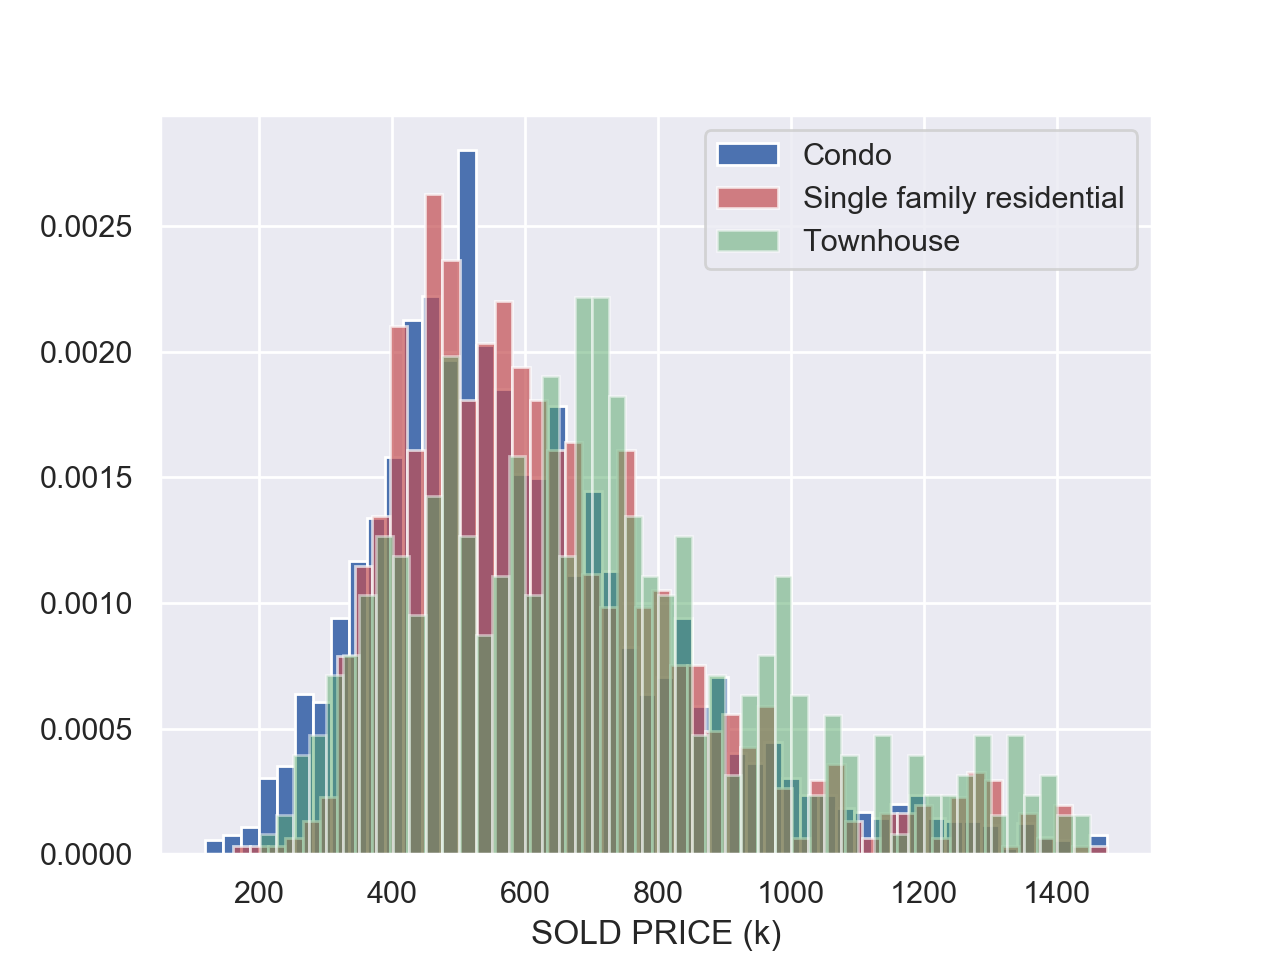

In [47]:
fig = plt.figure()
plt.hist(df[df['PROPERTY TYPE']=='Condo/Co-op']['DAYS ON MKT'],
         bins=50,color='b',label='Condo',normed=True)
plt.hist(df[df['PROPERTY TYPE']=='Single Family Residential']['DAYS ON MKT'],
         bins=50,color='r',label='Single family residential',normed=True,alpha=0.7)
plt.hist(df[df['PROPERTY TYPE']=='Townhouse']['DAYS ON MKT'],
         bins=50,color='g',label='Townhouse',normed=True,alpha=0.5)
plt.legend(loc='best')
plt.xlabel('DAYS ON MKT')
plt.draw()

fig = plt.figure()
plt.hist(df[df['PROPERTY TYPE']=='Condo/Co-op']['SOLD PRICE']/1000,
         bins=50,color='b',label='Condo',normed=True)
plt.hist(df[df['PROPERTY TYPE']=='Single Family Residential']['SOLD PRICE']/1000,
         bins=50,color='r',label='Single family residential',normed=True,alpha=0.7)
plt.hist(df[df['PROPERTY TYPE']=='Townhouse']['SOLD PRICE']/1000,
         bins=50,color='g',label='Townhouse',normed=True,alpha=0.5)
plt.legend(loc='best')
plt.xlabel('SOLD PRICE (k)')
plt.show()


How different are the selling price and the days on market distributions for different properties? A Kolmogorov-Smirnov test tells if two distributions are significantly different (p-value < 0.05).

In [48]:
from scipy.stats import ks_2samp

days_on_mkt_ks_p_values = np.zeros((3,3))
sold_price_ks_p_values = np.zeros((3,3))
for i,i_prop in enumerate(['Condo/Co-op','Single Family Residential','Townhouse']):
    for j,j_prop in enumerate(['Condo/Co-op','Single Family Residential','Townhouse']):
        days_on_mkt_ks_p_values[i][j] = ks_2samp(df[df['PROPERTY TYPE']==i_prop]['DAYS ON MKT'].values,
                                                 df[df['PROPERTY TYPE']==j_prop]['DAYS ON MKT'].values)[1]
        sold_price_ks_p_values[i][j] = ks_2samp(df[df['PROPERTY TYPE']==i_prop]['SOLD PRICE'].values,
                                                df[df['PROPERTY TYPE']==j_prop]['SOLD PRICE'].values)[1]

print('DAYS OF MKT KS p-value')
print(days_on_mkt_ks_p_values)
print('SOLD PRICE KS p-value')
print(sold_price_ks_p_values)

DAYS OF MKT KS p-value
[[1.00000000e+00 6.09555812e-08 4.11426126e-05]
 [6.09555812e-08 1.00000000e+00 8.79302376e-02]
 [4.11426126e-05 8.79302376e-02 1.00000000e+00]]
SOLD PRICE KS p-value
[[1.00000000e+00 1.25304896e-04 1.12143497e-18]
 [1.25304896e-04 1.00000000e+00 1.64519065e-10]
 [1.12143497e-18 1.64519065e-10 1.00000000e+00]]


The distributions for different properties are significantly different, except for the days on market distribution of townhouse and single family residential (p-value = 0.088). Visually, the histograms are very close to each other.  

# Price/sqft trend for different property types

Housing market is dynamic and price fluctuates. Conventional economic theory states that price should have zero autocorrelation or else there will be an arbitrage opportunity. However, house is much more illiquid than stock and there are considerably more friction (commissions to brokers). Therefore any non-zero autocorrelation trend can persist and such trend can in principle be used to estimate the selling price. I will particularly look at the daily average selling price time series.

<IPython.core.display.Javascript object>


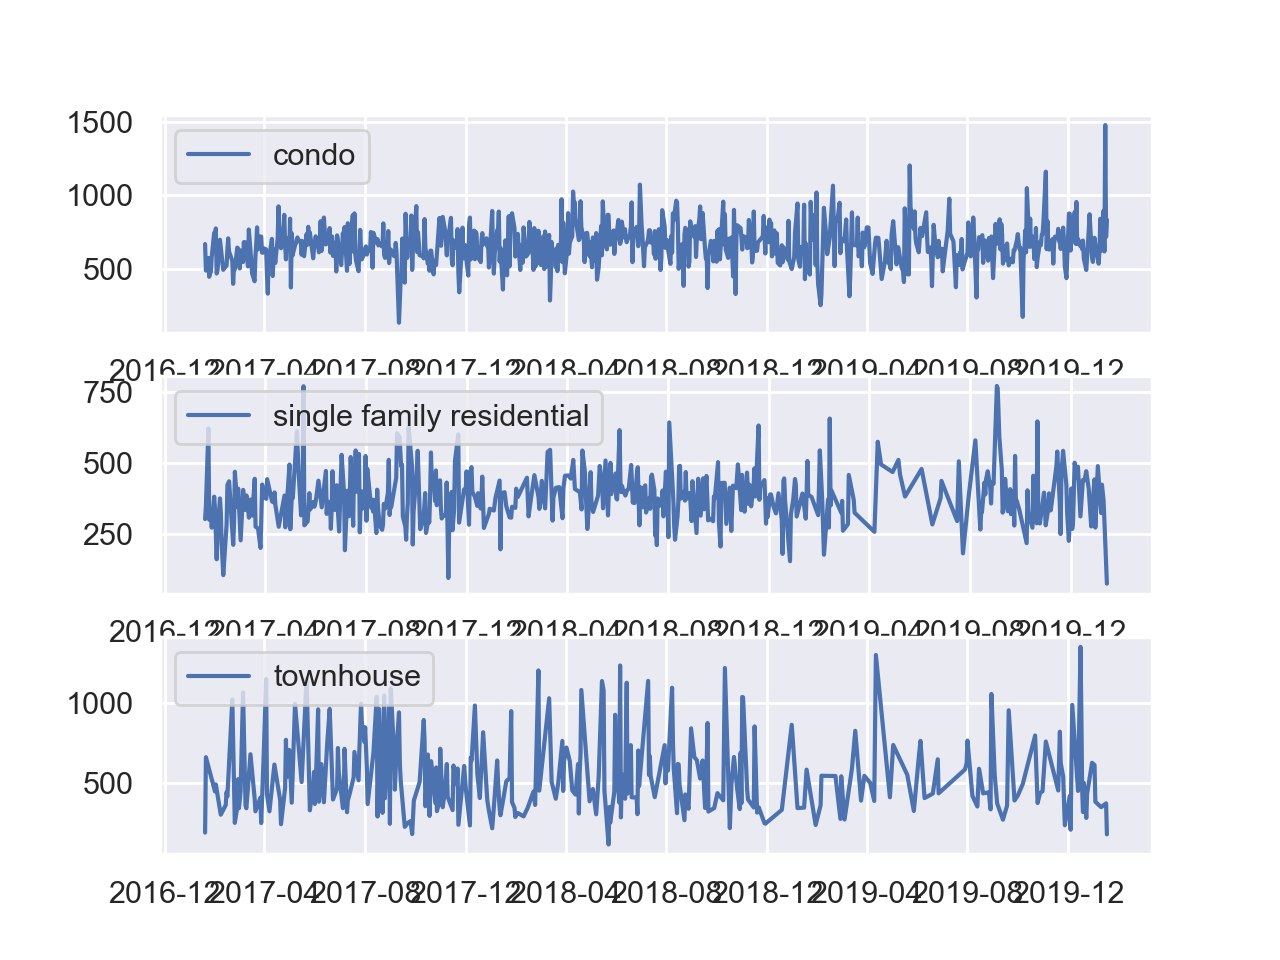

In [258]:
df = df.sort_values('SOLD DATE')

df_condo = df[df['PROPERTY TYPE'] == 'Condo/Co-op']
df_sfr = df[df['PROPERTY TYPE'] == 'Single Family Residential']
df_townhouse = df[df['PROPERTY TYPE'] == 'Townhouse']


df_condo_price_per_sqft = df_condo[['SOLD DATE','$/SQUARE FEET']].groupby('SOLD DATE').mean()
df_condo_days_on_mkt = df_condo[['SOLD DATE','DAYS ON MKT']].groupby('SOLD DATE').mean()
#df_condo_rolling_price_per_sqft = df_condo_price_per_sqft.rolling(5).mean()
#df_condo_rolling_days_on_mkt = df_condo_days_on_mkt.rolling(5).mean()

df_sfr_price_per_sqft = df_sfr[['SOLD DATE','$/SQUARE FEET']].groupby('SOLD DATE').mean()
df_sfr_days_on_mkt = df_sfr[['SOLD DATE','DAYS ON MKT']].groupby('SOLD DATE').mean()
#df_sfr_rolling_price_per_sqft = df_sfr_price_per_sqft.rolling(5).mean()
#df_sfr_rolling_days_on_mkt = df_sfr_days_on_mkt.rolling(5).mean()

df_townhouse_price_per_sqft = df_townhouse[['SOLD DATE','$/SQUARE FEET']].groupby('SOLD DATE').mean()
df_townhouse_days_on_mkt = df_townhouse[['SOLD DATE','DAYS ON MKT']].groupby('SOLD DATE').mean()
#df_townhouse_rolling_price_per_sqft = df_townhouse_price_per_sqft.rolling(5).mean()
#df_townhouse_rolling_days_on_mkt = df_townhouse_days_on_mkt.rolling(5).mean()

fig = plt.figure()
ax = fig.add_subplot(3,1,1)
plt.plot(df_condo_price_per_sqft.index,df_condo_price_per_sqft['$/SQUARE FEET'],label='condo')
plt.legend(loc='upper left')

ax = fig.add_subplot(3,1,2)
plt.plot(df_sfr_price_per_sqft.index,df_sfr_price_per_sqft['$/SQUARE FEET'],
         label='single family residential')
plt.legend(loc='upper left')

ax = fig.add_subplot(3,1,3)
plt.plot(df_townhouse_price_per_sqft.index,df_townhouse_price_per_sqft['$/SQUARE FEET'],
        label='townhouse')
plt.legend(loc='upper left')
plt.show()

# Autocorrelation of the change in price/sqft

<IPython.core.display.Javascript object>


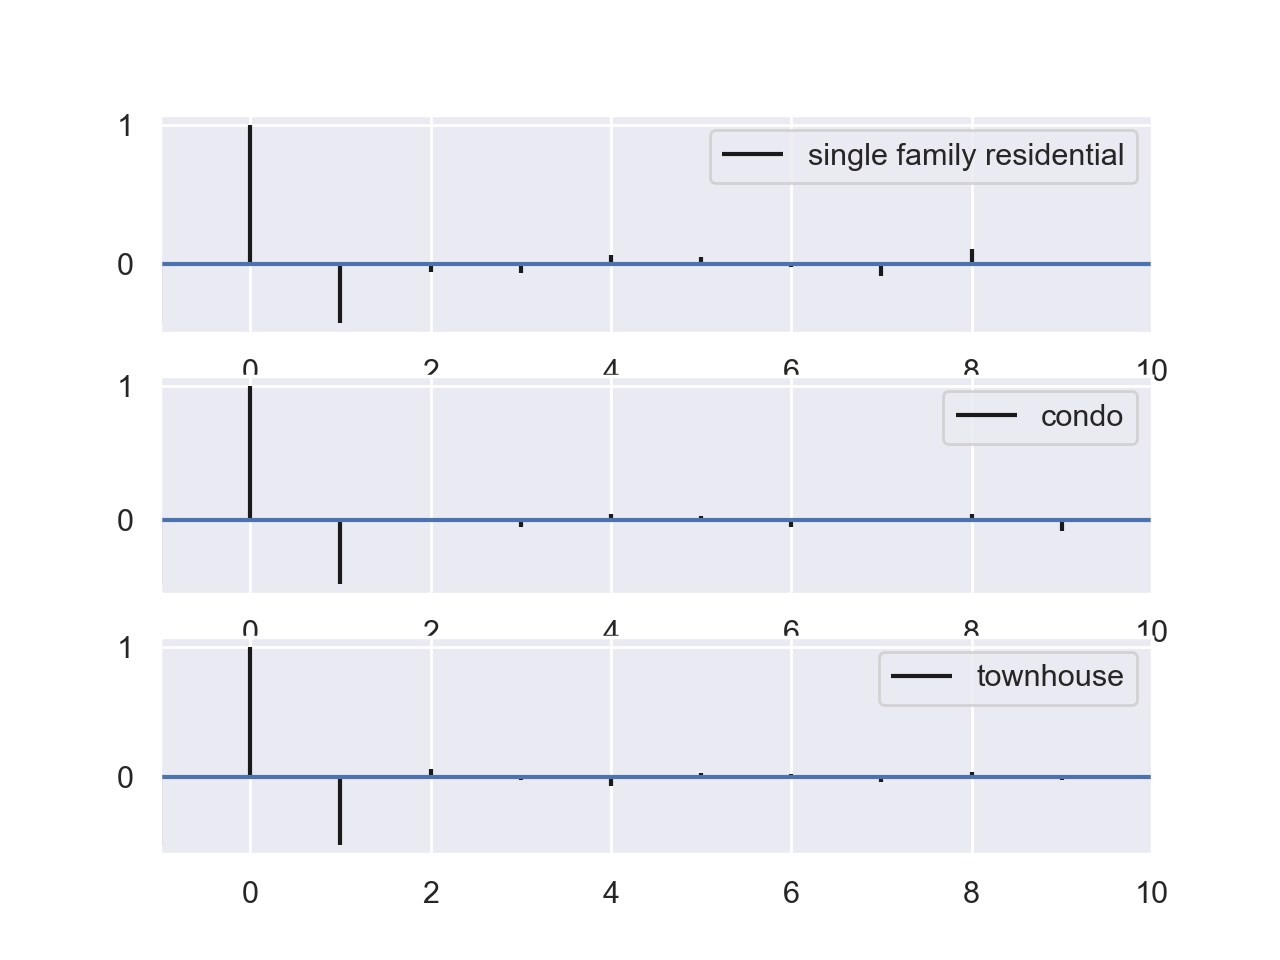

In [261]:
df_sfr_change_price_per_sqft = df_sfr_price_per_sqft - df_sfr_price_per_sqft.shift(1)
df_condo_change_price_per_sqft = df_condo_price_per_sqft - df_condo_price_per_sqft.shift(1)
df_townhouse_change_price_per_sqft = df_townhouse_price_per_sqft - df_townhouse_price_per_sqft.shift(1)



fig = plt.figure()
ax1 = fig.add_subplot(3,1,1)
#autocorr = [df_sfr_change_price_per_sqft.apply(lambda col: col.autocorr(i)) for i in range(10)]
plt.acorr(df_sfr_change_price_per_sqft[1:].values.reshape(-1,),maxlags=9,label='single family residential')
ax1.set_xlim([-1,10])
plt.legend(loc='upper right')

ax2 = fig.add_subplot(3,1,2)
#autocorr = [df_condo_change_price_per_sqft.apply(lambda col: col.autocorr(i)) for i in range(10)]
plt.acorr(df_condo_change_price_per_sqft[1:].values.reshape(-1,),maxlags=9,label='condo')
ax2.set_xlim([-1,10])
plt.legend(loc='upper right')

ax3 = fig.add_subplot(3,1,3)
#autocorr = [df_townhouse_change_price_per_sqft.apply(lambda col: col.autocorr(i)) for i in range(10)]
plt.acorr(df_townhouse_change_price_per_sqft[1:].values.reshape(-1,),maxlags=9,label='townhouse')
plt.legend(loc='upper right')
ax3.set_xlim([-1,10])
plt.show()


Across different property type, there is a consistent anti-correlation trend between today's average selling price and tomorrow's average selling price. The autocorrelation however decays quickly after first day. The result suggests that it can be useful to predict house price using only historical price trend. There is one last thing left to check: even if we can predict the daily average price perfectly, how useful will that number be in predict the price of a particular house? We can answer this question by looking at the intra day price variance.

# How useful is the trend in predicting the home price?


If we can perfectly predict the daily average price, how good can we predict the selling price of a particular house?

In [266]:
from sklearn.metrics import r2_score, mean_squared_error

def predict_daily_price(df_est_price,df_property):

    dict_date_price = {df_est_price.index[i]:
                  price for i,price in enumerate((df_est_price))}

    df_est_price = df_property['SOLD DATE'].apply(
        lambda x: dict_date_price[x] if x in dict_date_price else None)
    df_est_price.name = 'EST $/SQUARE FEET'

    df_joint = df_property[['PRICE','SQUARE FEET']].join(df_est_price,how='inner')
    df_joint['EST PRICE'] = df_joint['SQUARE FEET']*df_joint['EST $/SQUARE FEET']

    df_joint = df_joint.dropna()

    return df_joint['EST PRICE'].values, df_joint['PRICE'].values
    
print('townhouse: ')
est_price,true_price = predict_daily_price(df_townhouse_price_per_sqft['$/SQUARE FEET'],df_townhouse)
                                                                              
print('r2 score: ',r2_score(true_price,est_price))
print('MSE: ',mean_squared_error(true_price,est_price))
print('MAE: ',np.mean(np.abs(true_price-est_price)/true_price))
print('')

print('single family residential: ')
est_price,true_price = predict_daily_price(df_sfr_price_per_sqft['$/SQUARE FEET'],df_sfr)
                                                                              
print('r2 score: ',r2_score(true_price,est_price))
print('MSE: ',mean_squared_error(true_price,est_price))
print('MAE: ',np.mean(np.abs(true_price-est_price)/true_price))
print('')

print('condo: ')
est_price,true_price = predict_daily_price(df_condo_price_per_sqft['$/SQUARE FEET'],df_condo)
                                                                              
print('r2 score: ',r2_score(true_price,est_price))
print('MSE: ',mean_squared_error(true_price,est_price))
print('MAE: ',np.mean(np.abs(true_price-est_price)/true_price))
print('')

townhouse: 
r2 score:  0.3332520609348397
MSE:  48556978507.181694
MAE:  0.20251810937321854

single family residential: 
r2 score:  0.5221719137233463
MSE:  25502194162.276405
MAE:  0.1782865651987325

condo: 
r2 score:  -0.04214550021880248
MSE:  56153149839.132416
MAE:  0.32652722395137274



Comparing the performance to the most naive method, i.e. today's average selling price = next day's average selling price  

In [267]:
print('townhouse: ')
est_price,true_price = predict_daily_price(df_townhouse_price_per_sqft['$/SQUARE FEET'].shift(1),df_townhouse)
                                                                              
print('r2 score: ',r2_score(true_price,est_price))
print('MSE: ',mean_squared_error(true_price,est_price))
print('MAE: ',np.mean(np.abs(true_price-est_price)/true_price))
print('')

print('single family residential: ')
est_price,true_price = predict_daily_price(df_sfr_price_per_sqft['$/SQUARE FEET'].shift(1),df_sfr)
                                                                              
print('r2 score: ',r2_score(true_price,est_price))
print('MSE: ',mean_squared_error(true_price,est_price))
print('MAE: ',np.mean(np.abs(true_price-est_price)/true_price))
print('')

print('condo: ')
est_price,true_price = predict_daily_price(df_condo_price_per_sqft['$/SQUARE FEET'].shift(1),df_condo)
                                                                              
print('r2 score: ',r2_score(true_price,est_price))
print('MSE: ',mean_squared_error(true_price,est_price))
print('MAE: ',np.mean(np.abs(true_price-est_price)/true_price))
print('')


townhouse: 
r2 score:  -2.7763681831298634
MSE:  274833508372.19464
MAE:  0.6205937429934719

single family residential: 
r2 score:  -0.31666780885479917
MSE:  70390160557.24944
MAE:  0.3204931693821363

condo: 
r2 score:  -0.46796765172586663
MSE:  79068395315.72754
MAE:  0.3941800353038668



There is a potential lift (66% for townhouse, 47% for single family residential and 18%) if we can make perfect prediction about the daily average selling price compared to the naive method.